In [3]:
import pymc as pm
import pandas as pd
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import arviz as az

                  AMZN        AAPL        MSFT
Date                                          
2022-07-05  107.599998  137.770004  256.160004
2022-07-06  113.209999  141.350006  263.750000
2022-07-07  113.849998  143.289993  265.119995
2022-07-08  114.599998  145.259995  264.790009
2022-07-11  114.080002  145.669998  265.649994
2022-07-12  112.160004  145.759995  265.880005
2022-07-13  107.029999  142.990005  250.190002
2022-07-14  110.239998  144.080002  250.570007
2022-07-15  112.500000  149.779999  255.720001
2022-07-18  115.000000  150.740005  259.750000
AMZN    float64
AAPL    float64
MSFT    float64
dtype: object


<Axes: xlabel='Date'>

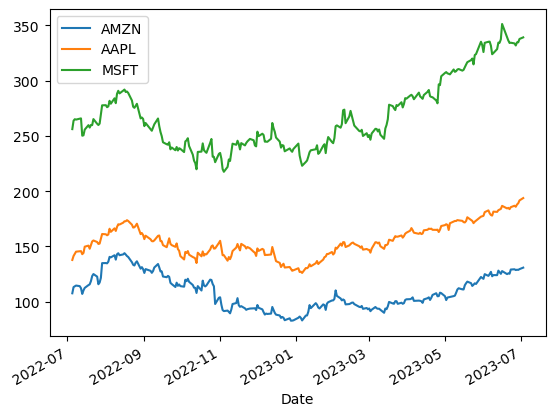

In [4]:
data = pd.read_csv("../../data/stocks.csv", parse_dates=True, index_col='Date')

# data["Date"] = pd.to_datetime(data["Date"])

print(data.head(10))
print(data.dtypes)

data.plot()

In [5]:
data.cov()

,AMZN,AAPL,MSFT
AMZN,246.104792,148.871991,247.951374
AAPL,148.871991,218.413037,437.131583
MSFT,247.951374,437.131583,1013.637551


<Axes: >

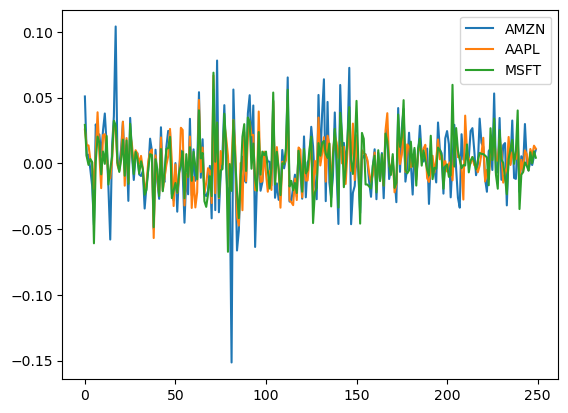

In [6]:
returns = pd.DataFrame()
for col in data.columns:
    returns[col] = [data[col].iloc[i+1]/ data[col].iloc[i] for i in range(data.shape[0]-1)]

log_returns= returns.apply(np.log)

log_returns.plot()


In [7]:
mu_hat = log_returns.mean()
s_hat = log_returns.cov()

print(mu_hat)
print(s_hat)

AMZN    0.000782
AAPL    0.001365
MSFT    0.001123
dtype: float64
          AMZN      AAPL      MSFT
AMZN  0.000760  0.000337  0.000374
AAPL  0.000337  0.000330  0.000251
MSFT  0.000374  0.000251  0.000386


In [8]:
model = pm.Model()

with model:
    chol, corr, stds = pm.LKJCholeskyCov("s", eta= 1.0,  n=3, sd_dist=pm.Lognormal.dist(np.zeros(3), np.ones(3), shape=3))
    cov = pm.Deterministic("cov", chol @ (chol.T))

    mu = pm.MvNormal("mu", mu=mu_hat.to_numpy(), chol = chol)

    R = pm.MvNormal("R", mu = mu, chol = chol, observed=log_returns)



In [9]:
print()

print(cov.eval())


[[ 0.22498227 -0.15250379 -0.10852357]
 [-0.15250379  0.38422496  0.20953348]
 [-0.10852357  0.20953348  0.81017096]]


In [10]:
with model:
    p_data = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, mu]


/home/james/miniconda3/envs/stats/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/james/miniconda3/envs/stats/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 348 seconds.


In [11]:
cov.eval()

array([[ 0.22498227, -0.15250379, -0.10852357],
       [-0.15250379,  0.38422496,  0.20953348],
       [-0.10852357,  0.20953348,  0.81017096]])

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

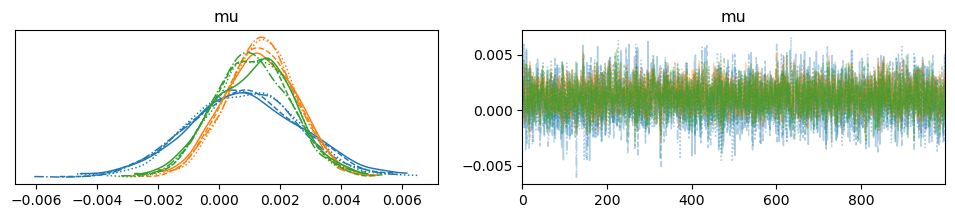

In [12]:
pm.plot_trace(p_data, var_names=['mu'])

In [13]:
# az.summary(p_data, round_to=5, kind='stats')
az.rhat(p_data, var_names=['mu', 'cov']).mu

<xarray.DataArray 'mu' (mu_dim_0: 3)>
array([1.00045816, 1.00144848, 1.00165263])
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2

array([[<Axes: title={'center': 'cov'}>, <Axes: title={'center': 'cov'}>]],
      dtype=object)

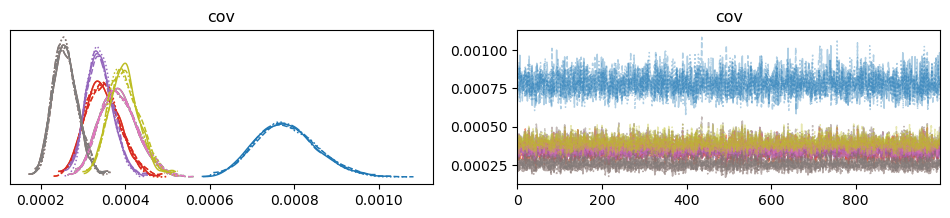

In [14]:
pm.plot_trace(p_data, var_names=['cov'])

In [15]:
p_data.posterior.mu[2].mean()

<xarray.DataArray 'mu' ()>
array(0.00108706)
Coordinates:
    chain    int64 2

In [16]:
az.summary(p_data.posterior)

/home/james/miniconda3/envs/stats/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.001,0.002,-0.002,0.004,0.000,0.0,2895.0,3063.0,1.0
mu[1],0.001,0.001,-0.001,0.004,0.000,0.0,2841.0,3062.0,1.0
mu[2],0.001,0.001,-0.001,0.003,0.000,0.0,2755.0,3137.0,1.0
s[0],0.028,0.001,0.026,0.030,0.000,0.0,3853.0,3224.0,1.0
s[1],0.012,0.001,0.011,0.014,0.000,0.0,3624.0,3356.0,1.0
s[2],0.014,0.001,0.012,0.015,0.000,0.0,4593.0,2787.0,1.0
s[3],0.014,0.001,0.012,0.016,0.000,0.0,3510.0,3261.0,1.0
s[4],0.006,0.001,0.005,0.008,0.000,0.0,4753.0,3301.0,1.0
s[5],0.013,0.001,0.012,0.014,0.000,0.0,6025.0,3007.0,1.0
"s_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,0.0,4000.0,4000.0,NaN


In [17]:
print(p_data.posterior.cov.data[-1][0])
print(p_data.posterior.mu.data[-1][0])

[[0.00086897 0.00037911 0.00045046]
 [0.00037911 0.00038849 0.00029974]
 [0.00045046 0.00029974 0.00043057]]
[0.00096015 0.00124124 0.00046873]


log scaling ?

In [18]:
def sharpe_ratio(x, s: np.ndarray, mu: np.ndarray, R: float)-> float:
    return (x.T @ mu - R)/(np.sqrt(x.T @ s @ x))

def constraint(x):
    return sum(x) - 1

def optimise(s: np.ndarray, mu: np.ndarray, R: float):
    size = mu.shape[0]
    init = 1/size * np.ones(size)
    bounds = tuple([(0,1) for _ in range(size)])

    return optimize.minimize(
        lambda x: -sharpe_ratio(x,s,mu,R),
        bounds=bounds,
        x0=init,
        constraints=({'type': 'eq', 'fun':constraint}),
    )



In [19]:
optimise(s_hat, mu_hat, 0)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07540480185496254
       x: [ 0.000e+00  8.942e-01  1.058e-01]
     nit: 8
     jac: [ 3.758e-02 -1.445e-05  1.221e-04]
    nfev: 32
    njev: 8

In [20]:
weights = []

for j in range(4):
    for i in range(1000):
        opt = optimise(s=p_data.posterior.cov.data[j][i], mu = p_data.posterior.mu.data[j][i], R = np.log(0.02))
        weights.append(opt.x)

weights = np.array(weights)

In [21]:
av_weights = np.mean(weights, axis=0)

print(av_weights)

[1.47686245e-04 6.31445461e-01 3.68406852e-01]


So we should be investing 11% into AMZN, 26% into AAPL and 63% into MSFT. If we had invested £100 when records began here according to this

In [22]:
shares = {
    "AMZN": 100*av_weights[0]/data['AMZN'][0],
    "AAPL": 100*av_weights[1]/data['AAPL'][0],
    "MSFT": 100*av_weights[2]/data['MSFT'][0],
}



print(sum([shares[k]*(data[k].tail(1)) for k in shares.keys()]))


Date
2023-07-03    137.615713
dtype: float64


Making us a nice 38% profit 

And now considering more traditional methods

In [23]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

cleaned_weights

OrderedDict([('AMZN', 0.0), ('AAPL', 0.9605), ('MSFT', 0.0395)])

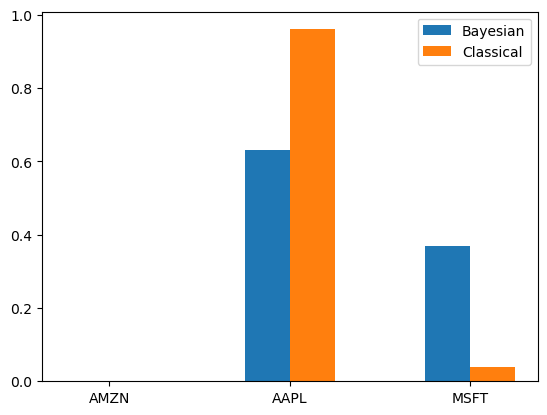

In [24]:
r=np.arange(3)
width = 0.25


plt.bar(height=av_weights, x = r, width=width, label='Bayesian')
plt.bar(height=cleaned_weights.values(), x=r+width, width=width, label='Classical')



plt.xticks(r+width/2, cleaned_weights.keys())
plt.legend()